In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.surround_view import convert_bird_eye_view, blend_bird_eye_img

In [2]:
front_img = cv2.imread('save_img\\front_img.jpg')
front_img = cv2.cvtColor(front_img, cv2.COLOR_RGB2BGR)

left_img = cv2.imread('save_img\\left_img.jpg')
left_img = cv2.cvtColor(left_img, cv2.COLOR_RGB2BGR)

right_img = cv2.imread('save_img\\right_img.jpg')
right_img = cv2.cvtColor(right_img, cv2.COLOR_RGB2BGR)

rear_img = cv2.imread('save_img\\rear_img.jpg')
rear_img = cv2.cvtColor(rear_img, cv2.COLOR_RGB2BGR)

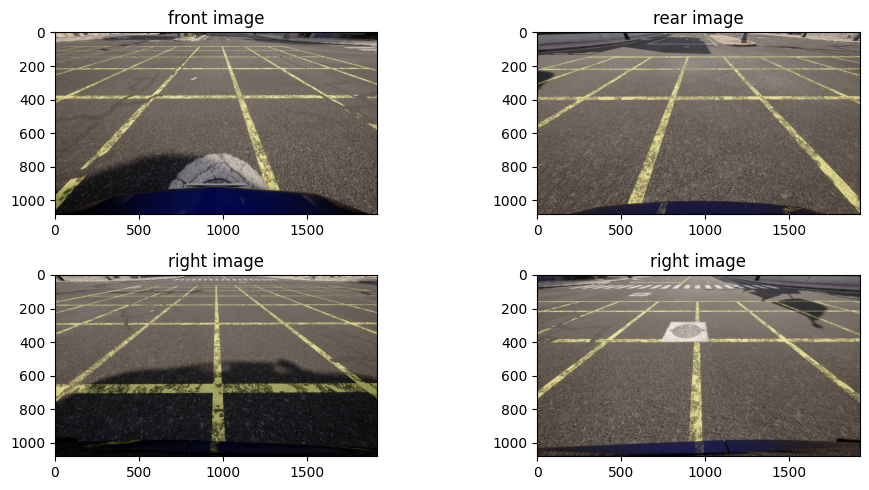

In [17]:
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 5)
axis[0, 0].imshow(front_img)
axis[0, 0].set_title('front image')

axis[0, 1].imshow(rear_img)
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_img)
axis[1, 0].set_title('right image')

axis[1, 1].imshow(right_img)
axis[1, 1].set_title('right image')

plt.tight_layout()

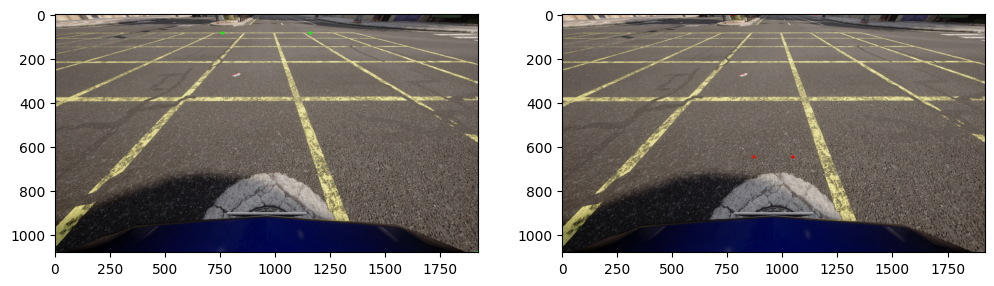

In [4]:
h, w, c = front_img.shape

src_h_ratio = 0.08
src_w_ratio_offset = 0.104

dst_h_ratio = 0.6
dst_w_ratio = 0.0463

src_pts = np.array([[w * (0.5-src_w_ratio_offset), h * src_h_ratio], [w * (0.5+src_w_ratio_offset), h * src_h_ratio], [w, h], [0, h]], dtype=np.float32)
dst_pts = np.array([[w*0.4, 0], [w*0.6, 0], [w*(0.5+dst_w_ratio), h*dst_h_ratio], [w*(0.5-dst_w_ratio), h*dst_h_ratio]], dtype=np.float32)

front_img_copy_1 = front_img.copy()
front_img_copy_2 = front_img.copy()

for pos in src_pts:
    pos = pos.astype(np.int32)
    cv2.circle(img=front_img_copy_1, center=pos, radius=2, color=(0, 255, 0), thickness=10)

for pos in dst_pts:
    pos = pos.astype(np.int32)
    cv2.circle(img=front_img_copy_2, center=pos, radius=2, color=(255, 0, 0), thickness=10)

fig, axis = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
axis[0].imshow(front_img_copy_1)
axis[1].imshow(front_img_copy_2)

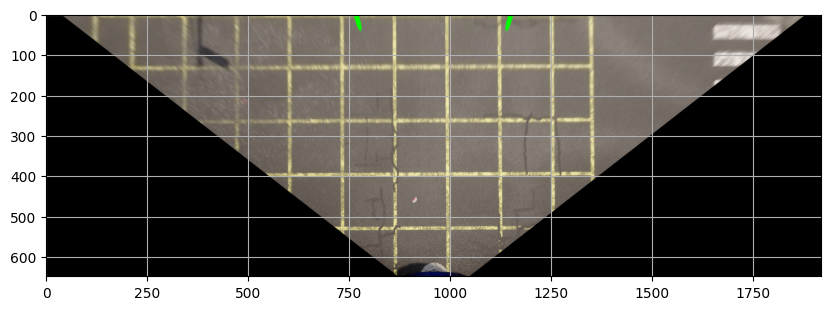

In [5]:
m = cv2.getPerspectiveTransform(src_pts, dst_pts)
dst_img = cv2.warpPerspective(src=front_img_copy_1, M=m, dsize=(w, int(h*dst_h_ratio)), flags=cv2.INTER_LINEAR)

plt.figure(figsize=(10, 10))
plt.grid()
plt.imshow(dst_img)

In [12]:
front_dst = convert_bird_eye_view(front_img)
left_dst = convert_bird_eye_view(left_img)
right_dst = convert_bird_eye_view(right_img)
rear_dst = convert_bird_eye_view(rear_img)

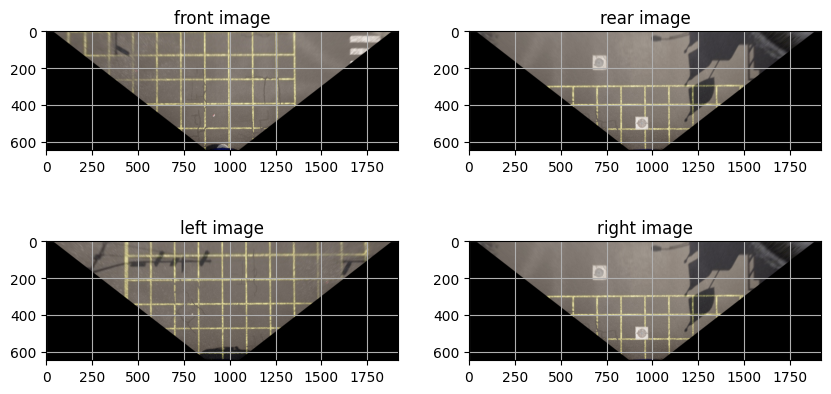

In [20]:
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 5)
axis[0, 0].imshow(front_dst)
axis[0, 0].grid()
axis[0, 0].set_title('front image')

axis[0, 1].imshow(right_dst)
axis[0, 1].grid()
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_dst)
axis[1, 0].grid()
axis[1, 0].set_title('left image')

axis[1, 1].imshow(right_dst)
axis[1, 1].grid()
axis[1, 1].set_title('right image')

dst_img_list = [front_dst, rear_dst, left_dst, right_dst]
dst_img_name_list =['front_dst.jpg', 'rear_dst.jpg','left_dst.jpg', 'right_dst.jpg']

for img_name, img in zip(dst_img_name_list, dst_img_list):
    cv2.imwrite('save_img\\'+img_name, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

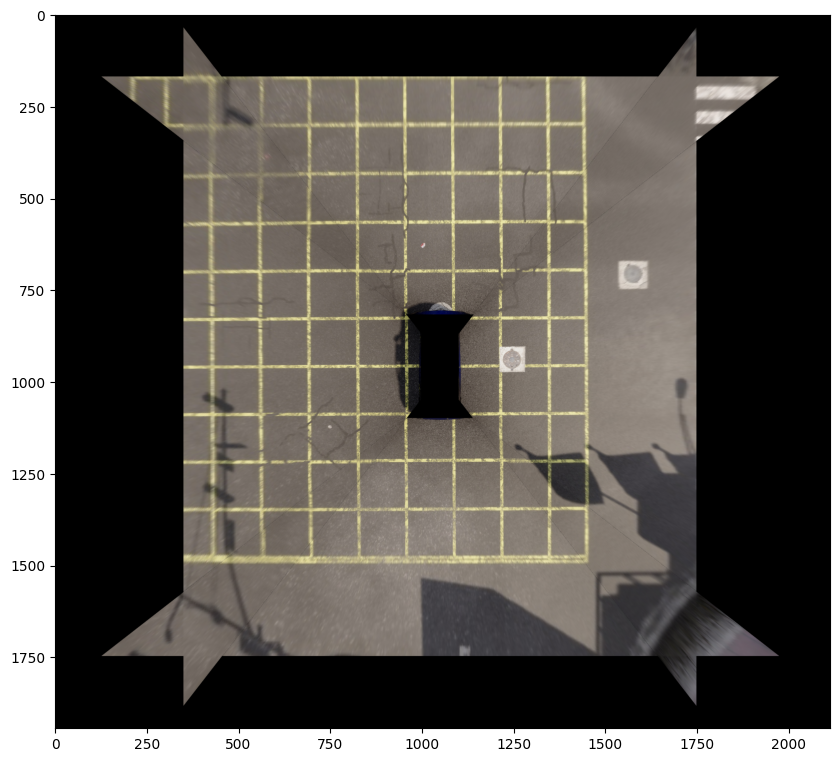

In [22]:
result = blend_bird_eye_img(front_dst, left_dst, right_dst, rear_dst)

plt.figure(figsize=(10, 10))
plt.imshow(result)

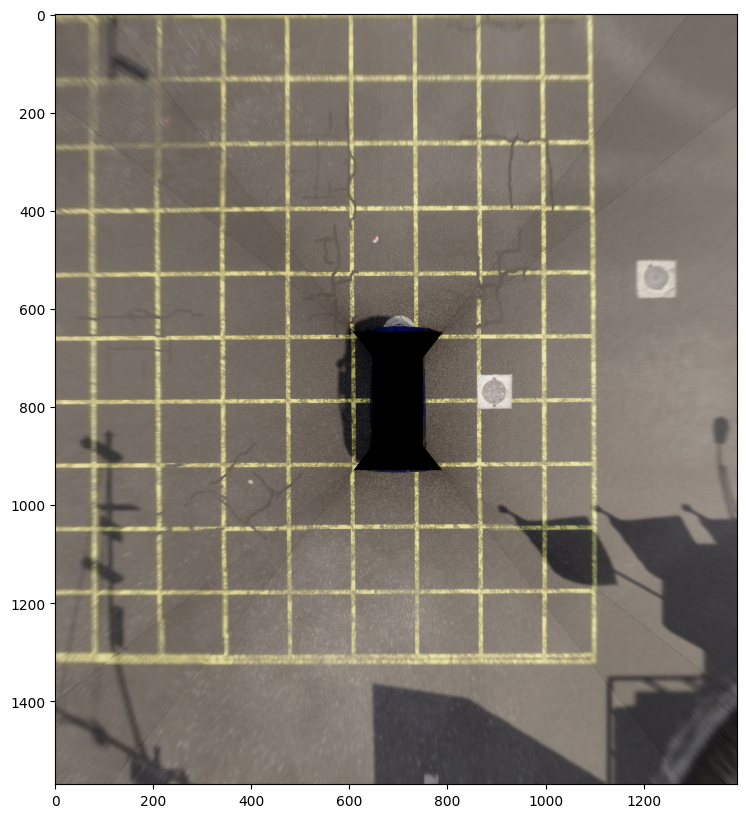

In [45]:
result_1 = result[170:1740, 350:1740]

plt.figure(figsize=(10, 10))
plt.imshow(result_1)